# Datafiles in the NWB format

We use the NWB data standard to store and share our multimodal neurophysiological recordings:

From the NWB  webiste https://www.nwb.org/:

> Neurodata Without Borders: Neurophysiology (NWB:N) is a data standard for neurophysiology, providing neuroscientists with a common standard to share, archive, use, and build analysis tools for neurophysiology data. NWB:N is designed to store a variety of neurophysiology data, including data from intracellular and extracellular electrophysiology experiments, data from optical physiology experiments, and tracking and stimulus data.

We rely on the python API to create such files, see:

https://pynwb.readthedocs.io/en/stable/

The script to build such data files is [build_NWB.py](./build_NWB.py) and we update those files (e.g. to add processed data) the script [update_NWB.py](./update_NWB.py)



In [1]:
# lading the python NWB API
import pynwb
import numpy as np # numpy for numerical analysis
import matplotlib.pylab as plt # + matplotlib for vizualization

In [2]:
# loading an example file
filename = '/media/yann/Yann/2020_11_12/17-54-24/2020_11_12-17-54-24.FULL.nwb'
io = pynwb.NWBHDF5IO(filename, 'r')
nwbfile = io.read() # don't forget to close afterwards !! (io.close() )

In [3]:
# let's have a look at what is inside
print(nwbfile)

root pynwb.file.NWBFile at 0x140383498645648
Fields:
  acquisition: {
    Photodiode-Signal <class 'pynwb.base.TimeSeries'>,
    Running-Speed <class 'pynwb.base.TimeSeries'>
  }
  experiment_description: full-field-drifting-gratings-5-orientations-10-repeats
  experimenter: ['Yann Zerlaut']
  file_create_date: [datetime.datetime(2021, 1, 5, 10, 26, 20, 210002, tzinfo=tzoffset(None, 3600))]
  identifier: 2020_11_12-17-54-24
  institution: Institut du Cerveau et de la Moelle, Paris
  lab: Rebola and Bacci labs
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_description: {'NIdaq-acquisition-frequency': 10000, 'NIdaq-analog-input-channels': 1, 'NIdaq-digital-input-channels': 2, 'protocol_folder': 'exp\\protocols', 'root_datafolder': 'DATA', 'FaceCamera-frame-rate': 20, 'VisualStim': True, 'Locomotion': True, 'Electrophy': False, 'FaceCamera': True, 'CaImaging': True, 'protocol': 'full-field-drifting-gratings-5-orientations-10-repeats', 'Presentation': 'Random

## Acquisition fields

In [4]:
nwbfile.acquisition

{'Photodiode-Signal': Photodiode-Signal pynwb.base.TimeSeries at 0x140383474622992
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (3600000,), type "<f8">
   description: no description
   rate: 10000.0
   resolution: -1.0
   starting_time: 0.0
   starting_time_unit: seconds
   unit: [current],
 'Running-Speed': Running-Speed pynwb.base.TimeSeries at 0x140383465081936
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (3595000,), type "<f8">
   description: no description
   rate: 10000.0
   resolution: -1.0
   starting_time: 0.0
   starting_time_unit: seconds
   unit: cm/s}

In [9]:
nwbfile.acquisition['FaceCamera-acquisition']._AbstractContainer__container_source

'/media/yann/Yann/2020_11_12/17-54-24/2020_11_12-17-54-24.FULL.nwb'

## Processing fields

In [5]:
print(nwbfile.processing)

{'ophys': ophys pynwb.base.ProcessingModule at 0x140383465082384
Fields:
  data_interfaces: {
    Backgrounds_0 <class 'pynwb.base.Images'>,
    Deconvolved <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>,
    Neuropil <class 'pynwb.ophys.Fluorescence'>
  }
  description: optical physiology processed data
}


Details:
-  "ophys" is the suite2p output
- add the pupil processing output
- add the Facemap output

### optical physiology output

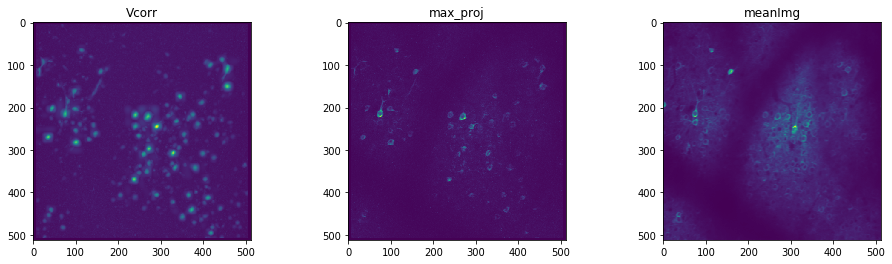

In [79]:
# "backgrounds_0" key
fig, AX = plt.subplots(1,3, figsize=(16,4))
for key, ax in zip(nwbfile.processing['ophys'].data_interfaces['Backgrounds_0'].images, AX):
    ax.imshow(nwbfile.processing['ophys'].data_interfaces['Backgrounds_0'].images[key][:])
    ax.set_title(key)
meanImg = nwbfile.processing['ophys'].data_interfaces['Backgrounds_0'].images['meanImg'][:] # we store this

In [139]:
# Image Segmentation output
print(nwbfile.processing['ophys'].data_interfaces['ImageSegmentation'].plane_segmentations)

{'PlaneSegmentation': PlaneSegmentation pynwb.ophys.PlaneSegmentation at 0x140383465221776
Fields:
  colnames: ['pixel_mask' 'iscell']
  columns: (
    pixel_mask_index <class 'hdmf.common.table.VectorIndex'>,
    pixel_mask <class 'hdmf.common.table.VectorData'>,
    iscell <class 'hdmf.common.table.VectorData'>
  )
  description: suite2p output
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  imaging_plane: ImagingPlane pynwb.ophys.ImagingPlane at 0x140383465221392
Fields:
  conversion: 1.0
  description: standard
  device: Microscope pynwb.device.Device at 0x140383465220304
Fields:
  description: My two-photon microscope
  manufacturer: The best microscope manufacturer

  excitation_lambda: 600.0
  imaging_rate: 30.0028382685002
  indicator: GCaMP
  location: V1
  optical_channel: (
    OpticalChannel <class 'pynwb.ophys.OpticalChannel'>
  )
  unit: meters

  reference_images: (
    TwoPhotonSeries <class 'pynwb.ophys.TwoPhotonSeries'>
  )
}


In [140]:
# fetch quantities
Segmentation = nwbfile.processing['ophys'].data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
pixel_masks_index = Segmentation.columns[0].data[:]
pixel_masks = Segmentation.columns[1].data[:]
iscell = Segmentation.columns[2].data[:,0].astype(bool)

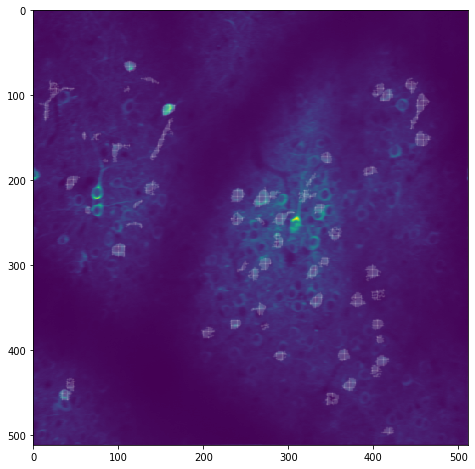

In [141]:
plt.figure(figsize=(10,8))
for i in np.arange(len(iscell))[iscell]:
    indices = np.arange(pixel_masks_index[i], pixel_masks_index[i+1])
    x, y = [pixel_masks[ii][1] for ii in indices], [pixel_masks[ii][0] for ii in indices]
    plt.scatter(x, y, color='w', alpha=0.05, s=1)
plt.imshow(meanImg)

(-8.330878491, 174.948448311, -3.042659968324006, 63.002031427063045)

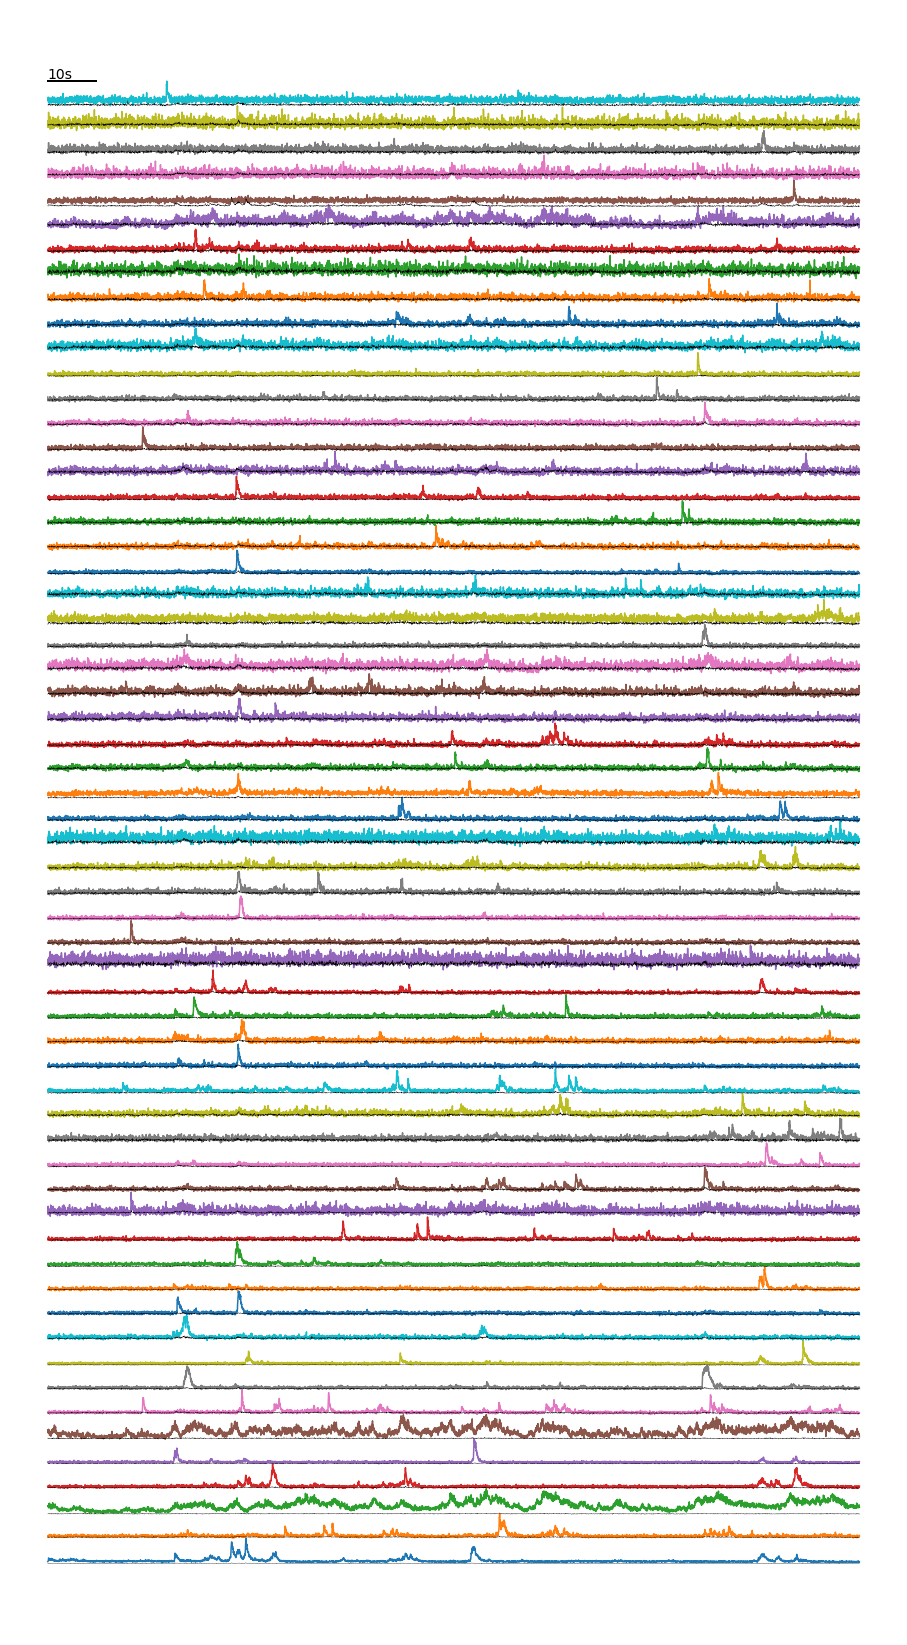

In [167]:
# Fluorescence and Neuropil
dt = 1./nwbfile.processing['ophys'].data_interfaces['Neuropil'].roi_response_series['Neuropil'].rate # in s
t = dt*np.arange(nwbfile.processing['ophys'].data_interfaces['Neuropil'].roi_response_series['Neuropil'].data.shape[1])
Fluorescence = nwbfile.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['Fluorescence']
Neuropil = nwbfile.processing['ophys'].data_interfaces['Neuropil'].roi_response_series['Neuropil']
# we plot just the first 5000 time samples

plt.figure(figsize=(16,30))
for k, i in enumerate(np.arange(len(iscell))[iscell]):
    fluo_resp = Fluorescence.data[i,:5000]
    nrp_resp = Neuropil.data[i,:5000]
    plt.plot(t[:5000],k+(fluo_resp-fluo_resp.min())/(fluo_resp.max()-fluo_resp.min()))
    plt.plot(t[:5000],k+(nrp_resp-fluo_resp.min())/(fluo_resp.max()-fluo_resp.min()), 'k', lw=0.3)
plt.plot([0,10], [k+1,k+1], 'k-', lw=2)
plt.annotate('10s', (0,k+1.1), size=14)
plt.axis('off')

In [168]:
io.close()